In [152]:
import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2


# donotdelete = []
print(sys.version)

3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [138]:
fpath_bkg =OrderedDict()
tree_bkg = OrderedDict()
tree_sig = OrderedDict()
fpath_sig =OrderedDict()
path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/V1p7/MC_Summer16/v11/v5/'
bkg_path = path+"/bkg/wH/normalized/"
# fpath_bkg['QCD'] = bkg_path+"QCD_HT50toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root"
# fpath_bkg['DYJetsToLL'] = bkg_path+"DYJetsToLL_M-50_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8_1pb_weighted.root"
# fpath_bkg['TTJets_DiLept'] = bkg_path+"TTJets_DiLept_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root"
# fpath_bkg['TTJets_SingleLeptFromTbar'] = bkg_path+"TTJets_SingleLeptFromTbar_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root"
# fpath_bkg['TTJets_SingleLeptFromT'] = bkg_path+"TTJets_SingleLeptFromT_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root"
# fpath_bkg['ZJetsToNuNu'] = bkg_path+"ZJetsToNuNu_Zpt-100toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8_1pb_weighted.root"
# fpath_bkg['bbbb10'] = '/mnt/hadoop/store/group/phys_exotica/delayedjets/llpntuple/V1p7/MC_Summer16/v1/sixie/WminusH_HToSSTobbbb_WToLNu_MH-125_MS-40_ctauS-10000_TuneCUETP8M1_13TeV-powheg-pythia8/Run2_LLPNtupler_V1p7_MC_Summer16_RunIISummer16DR80Premix-PUMoriond17_80X_mcRun2_asymptotic_2016_TrancheIV_v6-v1_v1_v1/190819_001050/0000/llp_ntupler_1.root'
fpath_bkg['bbbb1'] = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/signal.root'
NEvents = {}


for k,v in fpath_bkg.items():
    print (k, v)
#     tree[k] = rtnp.root2array(v)
    root_dir = uproot.open(v) 
#     if k[:7] == 'ntuples':
    tree_bkg[k] = root_dir['ntuples']['llp']
    NEvents[k] = root_dir['ntuples']['NEvents'][1]
#     else:
#     tree_bkg[k] = root_dir['MuonSystem']
#     NEvents[k] = root_dir['NEvents'][1]
#     tree[k] = root_dir['ntuples']
#     a = tree_bkg[k]["weight"].array()
#     print ('weights',np.unique(a)*lumi)
#     print(len(a))
#     print(len(a)/ NEvents[k])
#     print(a.shape)


bbbb1 /storage/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/signal.root


In [139]:
gLLP_decay_vertex = {}
gLLP_beta = {}
ctau = {}
genVertex = {}
gamma = {}
weight = {}
original_ctau = 100 #in cm
new_ctau = 500 #in cm
for k,T in tree_bkg.items():
#     genVertex[k] = np.sqrt(T.array('genVertexX')**2+T.array('genVertexY')**2+T.array('genVertexZ')**2)
#     genVertex[k] = np.column_stack((genVertex[k],genVertex[k]))
    gLLP_decay_vertex[k] = np.sqrt(T.array('gLLP_decay_vertex_x')**2+T.array('gLLP_decay_vertex_y')**2+T.array('gLLP_decay_vertex_z')**2)

    gLLP_beta[k] = T.array('gLLP_beta')
    gamma[k] = 1.0/np.sqrt(1-gLLP_beta[k]**2)
    ctau[k] = (gLLP_decay_vertex[k])/(gLLP_beta[k]*gamma[k])
#     ctau[k] = np.sum(ctau[k], axis = 1)
#     print(np.sum(ctau[k], axis = 1))
    weight[k] = np.exp(np.sum(ctau[k], axis = 1)*(1.0/original_ctau - 1.0/new_ctau))*(original_ctau*1.0/new_ctau)**2

# plot ctau

In [ ]:

c = rt.TCanvas('c','c', 800, 800)
# h.SetStats(0)
leg = rt.TLegend(0.60,0.80,0.90,0.90)
leg.SetTextSize(0.022)
leg.SetBorderSize(0)

leg.SetEntrySeparation(0.01)
h = {}
rt.gStyle.SetOptFit(1011)

k = 'bbbb1'
bins = [50,0,1000]
print(ctau[k].shape)
h[k] = create_TH1D( ctau[k].flatten(), axis_title=['c#tau [cm]', 'Events'], name=k, binning=bins)
w = np.transpose(np.vstack((weight[k],weight[k])))
h[k+'weight'] = create_TH1D( ctau[k].flatten(), axis_title=['c#tau [cm]', 'Events'], name=k+'weight', binning=bins,weights = w.flatten())

bins = [50,0,5000]
h[k] = create_TH1D( gLLP_decay_vertex[k].flatten(), axis_title=['decay vertex [cm]', 'Events'], name=k, binning=bins)
w = np.transpose(np.vstack((weight[k],weight[k])))
h[k+'weight'] = create_TH1D( gLLP_decay_vertex[k].flatten(), axis_title=['decay vertex [cm]', 'Events'], name=k+'weight', binning=bins,weights = w.flatten())

# bins = [50,0,10000]
# h[k] = create_TH1D( gamma[k].flatten(), axis_title=['#gamma[cm]', 'Events'], name=k, binning=bins)
# w = np.transpose(np.vstack((weight[k],weight[k])))
# h[k+'weight'] = create_TH1D( gamma[k].flatten(), axis_title=['decay vertex [cm]', 'Events'], name=k+'weight', binning=bins,weights = w.flatten())




# h[k+'weight'] = create_TH1D( ctau[k][:,1], axis_title=['c#tau [cm]', 'Events'], name=k+'weight', binning=bins,weights = weight[k])

# h[k+'weight'] = create_TH1D( ctau[k][:,0], axis_title=['c#tau [cm]', 'Events'], name=k+'weight', binning=bins,weights = weight[k])
h[k].SetLineColor(std_color_list[0])
h[k+'weight'].SetLineColor(std_color_list[1])

leg.AddEntry(h[k], k)
leg.AddEntry(h[k+'weight'],k+' weighted')
#     h[k].SetMinimum(1)
h[k].GetXaxis().SetLabelSize(0.04)
r = h[k].Fit('expo', 'LRSQ+0', '', 0,1000)
print(r.Get())
print(r.Prob())
h[k].GetFunction("expo").SetLineColor(std_color_list[0])
h[k].GetFunction("expo").SetLineStyle(2)
h[k].GetFunction("expo").SetLineWidth(2)
print('original ctau is: '+str(-1.0/r.Parameter(1)/100)+' m')
h[k].Draw()
h[k].GetFunction("expo").Delete()

r = h[k+'weight'].Fit('expo', 'LRSQ+0', 'a', 0,1000)
print(r.Get())
print(r.Prob())
# h[k+'weight'].GetFunction("expo").SetLineColor(std_color_list[1])
# h[k+'weight'].GetFunction("expo").SetLineStyle(2)
# h[k+'weight'].GetFunction("expo").SetLineWidth(2)
print('new ctau is: '+str(-1.0/r.Parameter(1)/100)+' m')
h[k+'weight'].Draw('same hist')


leg.Draw('same')
c.SetLogy()


c.Draw()

    
    


# c.Draw()
# print(time.time()-start_t)

# compare other variables

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: bbbb (Potential memory leak).


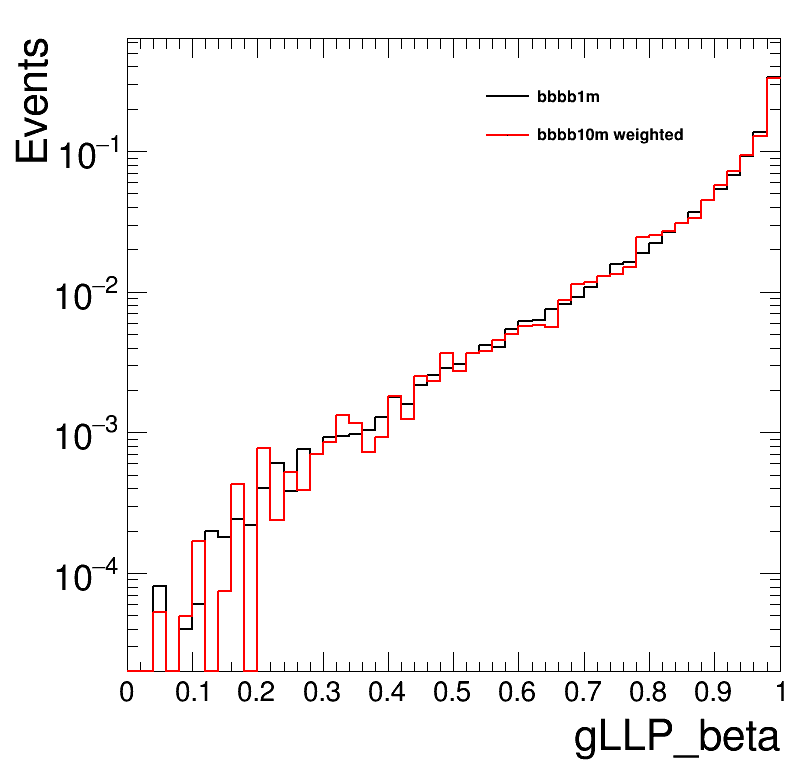

In [100]:
# Plotting ncsc
start_t = time.time()
c = rt.TCanvas('c','c', 1000, 800)
h = {}
# leg = rt.TLegend(0.50,0.75,0.97,0.93)
leg = rt.TLegend(0.58,0.70,0.94,0.85)
leg.SetTextSize(0.022)
# leg.SetTextFont(42)
leg.SetEntrySeparation(0.01)

i = 0
k = 'data_intime'

# h[k] = create_TH2D(np.column_stack((angle[k][cond],jetPt[k][cond][:,0])), axis_title = ['\Delta\phi (jet,met)','jet p_{T}[GeV]','Events'], binning=[80,-3.14,3.14,100,0,2000])
h[k] = create_TH2D(np.column_stack(( nCsc_JetMuonVetoCluster0p4_Me1112Veto[k], dphiMet_cluster[k])),
                   axis_title = ['N_{rechits}','\Delta\phi (cluster,met)','Events'], binning=[50,0,600,50,0,3.14])


h[k].GetXaxis().SetLabelSize(0.04)




h[k].SetLineColor(std_color_list[i])
# leg.AddEntry(h[k], k)
#     h[k].SetMaximum(10E5)
#     h[k].SetMinimum(1)
h[k].Draw('colz')
c.SetRightMargin(0.2)



# if setlog: 
c.SetLogz()
c.Draw()
print(time.time()-start_t)